In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from matplotlib import pyplot as plt, colors
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup
import nltk
from nltk import NaiveBayesClassifier
from nltk.metrics.scores import f_measure, precision, recall
import collections
pos = open("positive_emoji_v2.csv").read().split(",")
neg = open("negative_emoji_v2.csv").read().split(",")
#print("Positive emoji: {}\n\nNegative emoji: {}\n".format("".join(pos), "".join(neg)))
files = sorted(glob.glob("egypt tweets/egypt_tweets*.csv"))
#print(files)
pd.set_option('display.max_colwidth', -1)

In [2]:
%%time
try:
    train = pd.read_csv("train.csv", sep=";", engine="python")
except:
    train = []
    for f in tqdm(files):
        df = pd.read_csv(f, sep=";")
        feels = np.zeros(len(df), dtype=int)
        for i in tqdm(range(len(df))):
            html = df.html[i]
            if type(html) != str:
                continue
            feel = sum([e in html for e in pos]) - sum([e in html for e in neg])
            feels[i] = feel
        df["feel"] = feels
        train.append(df[df.feel != 0])
    train = pd.concat(train)
    print(len(train))
    text_with_emoji = np.empty(len(train), dtype=object)
    for i, html in enumerate(tqdm(train.html)):
        soup = BeautifulSoup(html, "lxml")
        s = []
        for child in soup.find("p").children:
            if child.name == None:
                s.append(child)
            elif child.name == "img":
                s.append(child["alt"])
            else:
                s.append(child.text)
        text_with_emoji[i] = " ".join(s)
    train.text = text_with_emoji
    train[["text", "feel"]].to_csv("train.csv", sep=";", index=False)

CPU times: user 2 s, sys: 117 ms, total: 2.11 s
Wall time: 2.11 s


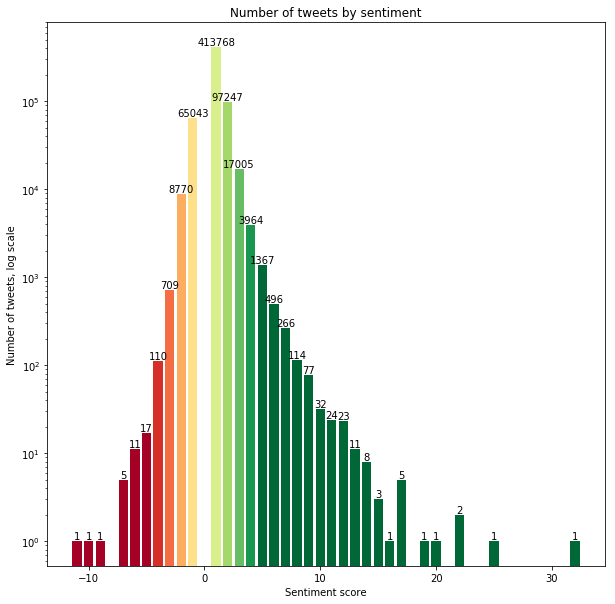

In [3]:
tvc = train.feel.value_counts().sort_index()
values = tvc.values
keys = tvc.keys()

plt.figure(figsize = (10,10))
cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=-5, vmax=5)
plt.bar(keys, values, color=cmap(norm(keys)))
plt.gca().set_yscale('log')
plt.title("Number of tweets by sentiment")
plt.ylabel("Number of tweets, log scale")
plt.xlabel("Sentiment score")

for i, v in enumerate(values):
    k = keys[i]
    plt.text(k, v, v, ha="center", va="bottom")